#%%[markdown]

 ## Meta-Learnig via RNNs in weight space
 Use a RNN for map data to a sequence of weights
 - The RNN is a a linear state space model with A and B: theta_{t+1} = A theta_t + B x_t
 - This should work on irregular time series data, since the theta_t is decoded and evaluated between (0,1)
 - The loss function compares the latent space'd decoded output to the ground thruth
# ToDo:
 - [] Why is my cros-entropy so bad, and optax so good ?
 - [] Try the Neural CDE irregular dataset
 - [] Add delta_t in front of the A matrix

In [ ]:
#%%

# %load_ext autoreload
# %autoreload 2

import jax

print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)
# config.update("jax_enable_x64", True)
# from jax.experimental import checkify

## Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import jax.numpy as jnp

## Import jax partial
from jax.tree_util import Partial

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx

# import matplotlib.pyplot as plt
from neuralhub import *
from loaders import TrendsDataset, MNISTDataset, CIFARDataset, CelebADataset
from selfmod import NumpyLoader, setup_run_folder, torch

import optax
import time

## Set seaborn style to talk
import seaborn as sb
sb.set_context("poster")

Available devices: [CudaDevice(id=0)]

############# Contextual Self-Modulation #############

Jax version: 0.4.35
Available devices: [CudaDevice(id=0)]


In [ ]:
#%%

SEED = 2024
main_key = jax.random.PRNGKey(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Model hps
mlp_hidden_size = 24*1
mlp_depth = 3
rnn_inner_dims = []
nb_rnn_layers = len(rnn_inner_dims) + 1

## Optimiser hps
init_lr = 1e-4
lr_decrease_factor = 0.5        ## Reduce on plateau factor

## Training hps
print_every = 1
nb_epochs = 2*60*4
batch_size = 64*2
unit_normalise = False
grounding_length = 2150          ## The length of the grounding pixel for the autoregressive digit generation
autoregressive_inference = True    ## Type of inference to use: If True, the model is autoregressive, else it remebers and regurgitates the same image 
full_matrix_A = True            ## Whether to use a full matrix A or a diagonal one
use_theta_prev = False          ## Whether to use the previous pevious theta in the computation of the next one
supervision_task = "reconstruction"       ## True for classification, reconstruction, or both
mini_res_mnist = 1
traj_train_prop = 1.0           ## Proportion of steps to sample to train each time series
weights_lim = 5e+2              ## Limit the weights of the root model to this value
weights_clip_scale = 2.         ## kappa from 
nb_recons_loss_steps = -1        ## Number of steps to sample for the reconstruction loss
train_strategy = "flip_coin"     ## "flip_coin", "teacher_forcing", "always_true"
use_mse_loss = False
resolution = (64, 64)
forcing_prob = 0.15
std_lower_bound = 1e-4              ## Let's optimise the lower bound
print(f"==== {supervision_task.capitalize()} Task ====")

train = False
dataset = "celeba"               ## mnist, cifar, or trends, mnist_fashion
data_folder = "./data/" if train else "../../data/"
image_datasets = ["mnist", "mnist_fashion", "cifar", "celeba"]

# run_folder = "./runs/250208-184005-Test/" if train else "./"
run_folder = None if train else "./"

==== Reconstruction Task ====


In [ ]:
#%%

### Create and setup the run folder
if run_folder==None:
    run_folder = make_run_folder('./runs/')
else:
    print("Using existing run folder:", run_folder)
_, checkpoints_folder, _ = setup_run_folder(run_folder, os.path.basename(__file__), None)

## Copy loaders script to the run folder
os.system(f"cp loaders.py {run_folder}");

Using existing run folder: ./
 Backed up run script and module files 


cp: 'main_wsm.py' and './main_wsm.py' are the same file
cp: '/home/gb21553/Projects/NeuralHub/examples/time-series/runs/250304-205114-BestCeleb64*/selfmod' and './selfmod' are the same file
cp: 'loaders.py' and './loaders.py' are the same file


 #### CelebA Dataset ####
Training sequence length: 4096
Images shape: (128, 4096, 3)
Labels shape: (128,)
Min and Max in the dataset: -1.0 1.0


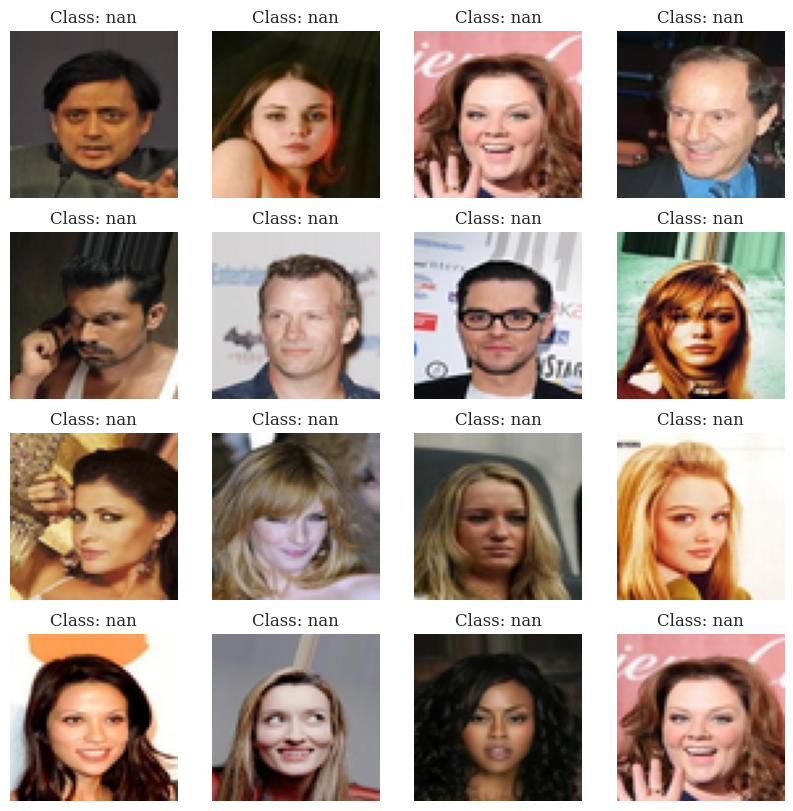

In [ ]:
#%%

if dataset in ["mnist", "mnist_fashion"]:
    # ### MNIST Classification (From Sacha Rush's Annotated S4)
    print(" #### MNIST Dataset ####")
    fashion = dataset=="mnist_fashion"
    trainloader = NumpyLoader(MNISTDataset(data_folder, data_split="train", mini_res=mini_res_mnist, traj_prop=traj_train_prop, unit_normalise=unit_normalise, fashion=fashion), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=24)
    testloader = NumpyLoader(MNISTDataset(data_folder, data_split="test", mini_res=mini_res_mnist, traj_prop=1.0, unit_normalise=unit_normalise, fashion=fashion),
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=24)
    nb_classes, seq_length, data_size = trainloader.dataset.nb_classes, trainloader.dataset.num_steps, trainloader.dataset.data_size
    print("Training sequence length:", seq_length)
elif dataset=="cifar":
    print(" #### CIFAR Dataset ####")
    trainloader = NumpyLoader(CIFARDataset(data_folder, data_split="train", mini_res=mini_res_mnist, traj_prop=traj_train_prop, unit_normalise=unit_normalise), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=24)
    testloader = NumpyLoader(CIFARDataset(data_folder, data_split="test", mini_res=mini_res_mnist, traj_prop=1.0, unit_normalise=unit_normalise),
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=24)
    nb_classes, seq_length, data_size = trainloader.dataset.nb_classes, trainloader.dataset.num_steps, trainloader.dataset.data_size
    print("Training sequence length:", seq_length)
elif dataset=="celeba":
    print(" #### CelebA Dataset ####")
    trainloader = NumpyLoader(CelebADataset(data_folder+"celeba/", data_split="train", num_shots=np.prod(resolution), resolution=resolution, order_pixels=True, unit_normalise=unit_normalise), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=24)
    testloader = NumpyLoader(CelebADataset(data_folder+"celeba/", data_split="test", num_shots=np.prod(resolution), resolution=resolution, order_pixels=True, unit_normalise=unit_normalise),
                                batch_size=batch_size, 
                                shuffle=True, 
                                num_workers=24)
    nb_classes, seq_length, data_size = trainloader.dataset.nb_classes, trainloader.dataset.num_steps, trainloader.dataset.data_size
    print("Training sequence length:", seq_length)

else:
    print(" #### Trends (Synthetic Control) Dataset ####")
    ## ======= below to run the easy Trends dataset instead!
    trainloader = NumpyLoader(TrendsDataset(data_folder+"trends/", skip_steps=1, traj_prop=traj_train_prop), 
                              batch_size=batch_size if batch_size<600 else 600, 
                              shuffle=True)
    testloader = NumpyLoader(TrendsDataset(data_folder+"trends/", skip_steps=1, traj_prop=1.0), 
                             batch_size=batch_size if batch_size<600 else 600,
                             shuffle=True)
    nb_classes, seq_length, data_size = trainloader.dataset.nb_classes, trainloader.dataset.num_steps, trainloader.dataset.data_size

batch = next(iter(testloader))
(images, times), labels = batch
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

print("Min and Max in the dataset:", jnp.min(images), jnp.max(images))

## Plot a few samples, along with their labels as title in a 4x4 grid (chose them at random)
fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True)
colors = ['r', 'g', 'b', 'c', 'm', 'y']

def get_width(dataset):
    if dataset in ["mnist", "mnist_fashion"]:
        return 28 // mini_res_mnist
    elif dataset=="cifar":
        return 32 // mini_res_mnist
    elif dataset=="celeba":
        return resolution[0]
    else:
        return 32

width = get_width(dataset)
res = (width, width, data_size)
for i in range(4):
    for j in range(4):
        idx = np.random.randint(0, images.shape[0])
        if dataset in image_datasets:
            to_plot = images[idx].reshape(res)
            if (not unit_normalise) and (dataset=="celeba"):  ## Images are between -1 and 1
                to_plot = (to_plot + 1) / 2
            axs[i, j].imshow(to_plot, cmap='gray')
        else:
            axs[i, j].plot(images[idx], color=colors[labels[idx]])
        axs[i, j].set_title(f"Class: {labels[idx]}", fontsize=12)
        axs[i, j].axis('off')

In [ ]:
# %%

def enforce_absonerange(x):
    return jax.nn.tanh(x)

def enforce_positivity(x):
    # return jnp.clip(jax.nn.softplus(x), 1e-6, 1)          ## Original code. This works! But may be optimal with tanh activation because softplus(-1) = 0.31 
    # return jnp.clip(jnp.abs(x), 1e-6, 1)                  ## Try this as well.
    # return jnp.clip((x+1.)/2., std_lower_bound, 1)                     ## If tanh activation was used
    # return jnp.clip(jax.nn.sigmoid(2*x), std_lower_bound, 1)                     ## Good but

    # return jnp.clip(jax.nn.softplus(x), std_lower_bound, None)                     ## As Godron et al.
    return jax.nn.softplus(x)       ## Will be clipped by the model.


class RootMLP(eqx.Module):
    network: eqx.Module
    props: any      ## Properties of the network
    final_activation: any

    def __init__(self, input_dim, output_dims, hidden_size, depth, activation, key=None):
        key = key if key is not None else jax.random.PRNGKey(0)
        keys = jax.random.split(key, num=2)

        final_activation = jax.nn.sigmoid if unit_normalise else jax.nn.tanh
        # final_activation = lambda x:x
        # self.network = eqx.nn.MLP(input_dim, output_dims, hidden_size, depth, activation, final_activation=final_activation, key=keys[0])
        # self.network = eqx.nn.MLP(input_dim, output_dims, hidden_size, depth, activation, key=keys[0])

        self.final_activation = final_activation
        self.network = eqx.nn.MLP(input_dim, output_dims, hidden_size, depth, activation, key=keys[0])

        self.props = (input_dim, output_dims, hidden_size, depth, activation)

    def __call__(self, t):
        out = self.network(t)
        if supervision_task=="reconstruction" and dataset in image_datasets:
            if use_mse_loss:
                return jax.nn.tanh(out)
            else:
                recons, stds = enforce_absonerange(out[:data_size]), enforce_positivity(out[data_size:])
                return jnp.concatenate([recons, stds], axis=-1)
        elif supervision_task=="classification":
            return out  ## Softmax is applied in the loss function
        else:
            raise NotImplementedError("Not supported for now")

## Define the global limits for the weights as a RootMLP
network_clip = None


# ## Define model and loss function for the learner
class Ses2Seq(eqx.Module):
    """ Sequence to sequence model which takes in an initial latent space """
    As: jnp.ndarray
    Bs: jnp.ndarray
    thetas: jnp.ndarray
    std_lb: jnp.ndarray

    root_utils: list
    inference_mode: bool
    data_size: int

    def __init__(self, 
                 data_size, 
                 width, 
                 depth, 
                 activation="relu",
                 rnn_inner_dims=[],
                 key=None):

        keys = jax.random.split(key, num=3)
        builtin_fns = {"relu":jax.nn.relu, "tanh":jax.nn.tanh, 'softplus':jax.nn.softplus}
        if supervision_task=="classification":
            out_size = nb_classes
        elif supervision_task=="reconstruction":
            if use_mse_loss:
                out_size = data_size
            else:      ## NLL loss
                out_size = 2*data_size
        else:
            if use_mse_loss:
                out_size = data_size + nb_classes
            else:      ## NLL loss
                out_size = 2*data_size + nb_classes

        rnn_in_layers = [data_size] + rnn_inner_dims
        rnn_out_layers = rnn_inner_dims + [out_size]
        B_out_shapes = rnn_in_layers[:-1] + [data_size]
        keys = jax.random.split(keys[2], num=nb_rnn_layers)
        thetas = []
        root_utils = []
        As = []
        Bs = []
        for i in range(nb_rnn_layers):
            root = RootMLP(1, rnn_out_layers[i], width, depth, builtin_fns[activation], key=keys[i])
            params, static = eqx.partition(root, eqx.is_array)
            weights, shapes, treedef = flatten_pytree(params)
            root_utils.append((shapes, treedef, static, root.props))
            thetas.append(weights)

            latent_size = weights.shape[0]
            A = jnp.eye(latent_size, latent_size) if full_matrix_A else jnp.ones((latent_size,))
            if use_theta_prev:
                A = A*0.
            As.append(A)
            Bs.append(jnp.zeros((latent_size, B_out_shapes[i])))

        self.root_utils = root_utils
        self.thetas = thetas
        self.As = As
        self.Bs = Bs

        self.inference_mode = False     ## Change to True to use the model autoregressively
        self.data_size = data_size
        self.std_lb = jnp.array([std_lower_bound])

        # ## Set the global limits for the weights
        # global network_clip 
        # network_clip = (self.thetas*)

    def __call__(self, xs, ts, aux):
        """ xs: (batch, time, data_size)
            theta: (latent_size)
            """
        alpha, key = aux

        def forward(xs_, ts_, k_):
            ## 1. Fine-tune the latents weights on the sequence we have

            ## Call the JAX scan across layers
            nb_rnn_layers = len(self.thetas)
            layer_keys = jax.random.split(k_, nb_rnn_layers)
            xs_orig = xs_

            for i in range(nb_rnn_layers):
                keys = jax.random.split(layer_keys[i], xs_.shape[0])
                final_layer = i==nb_rnn_layers-1

                ## Do a partial on f
                def f(carry, input_signal):
                    thet, x_prev, t_prev, x_prev_prev, step = carry
                    x_true, t_curr, key_ = input_signal
                    delta_t = t_curr - t_prev

                    A = self.As[i]
                    B = self.Bs[i]
                    root_utils = self.root_utils[i]

                    if supervision_task=="classification":
                        x_t = x_true
                    else:
                        if self.inference_mode:
                            if autoregressive_inference:        ## Autoregressive mode (with some grounding)
                                x_t = jnp.where(t_curr<grounding_length/seq_length, x_true, x_prev)
                            else:
                                x_t = x_true
                        else:
                            if train_strategy == "flip_coin":
                                x_t = jnp.where(jax.random.bernoulli(key_, forcing_prob), x_true, x_prev)
                            elif train_strategy == "teacher_forcing":
                                x_t = alpha*x_true + (1-alpha)*x_prev
                            else:
                                x_t = x_true

                    if full_matrix_A:
                        if use_theta_prev:
                            # thet_next = thet + A@(thet_prev) + B@(x_t - x_prev_prev)     ## Maybe devide by delta_t ?
                            raise NotImplementedError("Full matrix A with theta_prev not implemented yet")
                        else:
                            # thet_next = A@(thet) + B@(x_t - x_prev_prev)     ## Promising !
                            # thet_next = A@(thet) + B@(x_t)     ## Promising !
                            thet_next = A@thet + B@(x_t - x_prev_prev)     ## Promising !
                    else:
                        thet_next = A*thet + B@(x_t - x_prev_prev)

                    ## 2. Decode the latent space
                    thet_next = jnp.clip(thet_next, -weights_lim, weights_lim)
                    # jax.debug.print("Smallest and biggest values in thet_next: {} {}", jnp.min(thet_next), jnp.max(thet_next))

                    shapes, treedef, static, _ = root_utils
                    params = unflatten_pytree(thet_next, shapes, treedef)
                    root_fun = eqx.combine(params, static)
                    # ## Clip t between 0 and 1
                    # t_curr = jnp.clip(self.t, 0., 1.)
                    y_next = root_fun(t_curr + delta_t)

                    if supervision_task=="classification":
                        x_next_mean = x_true
                    else:
                        if not unit_normalise:
                            x_next_mean = y_next[:x_true.shape[0]]
                        else:
                            # x_next_mean = jax.nn.tanh(y_next[:x_true.shape[0]])
                            pass

                    return (thet_next, x_next_mean, t_curr, x_prev, step+1), (y_next, )

                sup_signal = xs_ if not final_layer else xs_orig        ## Supervisory signal
                (thet_final, _, _, _, _), (xs_, ) = jax.lax.scan(f, (self.thetas[i], sup_signal[0], -ts_[1:2], sup_signal[0], 0), (sup_signal, ts_[:, None], keys))

                if self.inference_mode and not autoregressive_inference and supervision_task!="classification": 
                    ### We reconstitute the model, and we apply the model at each step
                    shapes, treedef, static, _ = self.root_utils[i]
                    params = unflatten_pytree(thet_final, shapes, treedef)
                    root_fun = eqx.combine(params, static)
                    xs_ = eqx.filter_vmap(root_fun)(ts_[:, None])

            return xs_

        ## Batched version of the forward pass
        ks = jax.random.split(key, xs.shape[0])
        return eqx.filter_vmap(forward)(xs, ts, ks)

In [ ]:
# %%

model_keys = jax.random.split(main_key, num=2)

model = Ses2Seq(data_size=data_size, 
                width=mlp_hidden_size, 
                depth=mlp_depth, 
                activation="relu", 
                rnn_inner_dims=rnn_inner_dims,
                key=model_keys[0])

# if train_in_inference_mode:
#     model = eqx.tree_at(lambda m:m.inference_mode, model, True)
untrained_model = model
## Print the total number of learnable paramters in the model components
print(f"Number of learnable parameters in the root network: {count_params((model.thetas,))/1000:3.1f} k")
print(f"Number of learnable parameters in the seqtoseq: {count_params((model.As, model.Bs))/1000:3.1f} k")
print(f"Number of learnable parameters in the model: {count_params(model)/1000:3.1f} k")

Number of learnable parameters in the root network: 1.4 k
Number of learnable parameters in the seqtoseq: 1958.6 k
Number of learnable parameters in the model: 1960.0 k


In [ ]:
# %%

def loss_fn(model, batch, utils):
    (X_true, times), X_labels = batch       ## X: (batch, time, data_size) - Y: (batch, num_classes)

    if supervision_task=="classification":
        ## Categorical cross-entropy loss with optax
        X_classes = model(X_true, times, utils)     ## Y_hat: (batch, time, num_classes) 
        pred_logits = X_classes[:, -1, :]   ## We only care about the last prediction: (batch, num_classes)

        losses_c = optax.softmax_cross_entropy_with_integer_labels(pred_logits, X_labels)
        loss = jnp.mean(losses_c)

        # ## Use the NLL loss for this classification instead
        # loss = -jnp.mean(jax.nn.log_softmax(pred_logits)[:, X_labels])

        ## Use one hot encoding and MSE loss
        # X_labels_onehot = jax.nn.one_hot(X_labels, nb_classes)
        # loss = jnp.mean((X_labels_onehot - jax.nn.softmax(pred_logits))**2)

        # ## Use one hot encoding and NLL loss with fixed variance
        # X_labels_onehot = jax.nn.one_hot(X_labels, nb_classes)
        # means = jax.nn.softmax(pred_logits)
        # stds = jnp.ones_like(means) * 1e-1
        # loss = jnp.mean(jnp.log(stds) + 0.5*((X_labels_onehot - means)/stds)**2)

        ## Calculate accuracy
        acc = jnp.mean(jnp.argmax(pred_logits, axis=-1) == X_labels)
        return loss, (acc,)

    elif supervision_task=="reconstruction":
        ## Make a reconstruction loss
        X_recons = model(X_true, times, utils)     ## Y_hat: (batch, time, data_size) 
        alpha, key = utils

        if nb_recons_loss_steps != -1:
            ## Randomly sample 2 points in the sequence to compare
            # indices = jax.random.randint(key, (2,), 0, X_true.shape[1])
            # loss_r = optax.l2_loss(X_recons[:, indices], X_true[:, indices])

            batch_size, nb_timesteps = X_true.shape[0], X_true.shape[1]
            indices_0 = jnp.arange(batch_size)
            indices_1 = jax.random.randint(key, (batch_size, nb_recons_loss_steps), 0, nb_timesteps)

            X_recons_ = jnp.stack([X_recons[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)
            X_true_ = jnp.stack([X_true[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)
        else:
            X_recons_ = X_recons
            X_true_ = X_true

        if use_mse_loss:
            loss_r = optax.l2_loss(X_recons_, X_true_)
        else: ## Use the negative log likelihood loss
            means = X_recons_[:, :, :data_size]
            # stds = X_recons_[:, :, data_size:]
            stds = jnp.maximum(X_recons_[:, :, data_size:], model.std_lb)
            loss_r = jnp.log(stds) + 0.5*((X_true_ - means)/stds)**2

        loss = jnp.mean(loss_r)
        return loss, (loss,)

    else: ## Both classification and reconstruction: the data and the classes are concatenated in that order
        X_full = model(X_true, times, utils)     ## Y_hat: (batch, time, data_size+nb_classes)
        recons_size = data_size if use_mse_loss else 2*data_size
        X_recons, X_classes = X_full[:, :, :recons_size], X_full[:, :, recons_size:]
        alpha, key = utils

        if nb_recons_loss_steps != -1:
            batch_size, nb_timesteps = X_true.shape[0], X_true.shape[1]
            indices_0 = jnp.arange(batch_size)
            indices_1 = jax.random.randint(key, (batch_size, nb_recons_loss_steps), 0, nb_timesteps)

            X_recons_ = jnp.stack([X_recons[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)
            X_true_ = jnp.stack([X_true[indices_0, indices_1[:,j]] for j in range(nb_recons_loss_steps)], axis=1)
        else:
            X_recons_ = X_recons
            X_true_ = X_true

        if use_mse_loss:
            losses = optax.l2_loss(X_recons_, X_true_)
            loss_r = jnp.mean(losses)
        else: ## Use the negative log likelihood loss
            means = X_recons_[:, :, :data_size]
            # stds = X_recons_[:, :, data_size:]
            stds = jnp.maximum(X_recons_[:, :, data_size:], model.std_lb)
            losses = jnp.log(stds) + 0.5*((X_true_ - means)/stds)**2
            print("Losses shape:", losses.shape, stds.shape, means.shape, X_true_.shape)
            loss_r = jnp.mean(losses)

        losses_c = optax.softmax_cross_entropy_with_integer_labels(X_classes[:, -1, :], X_labels)
        loss_c = jnp.mean(losses_c)
        loss = loss_r + 1e-2*loss_c

        acc = jnp.mean(jnp.argmax(X_classes[:, -1, :], axis=-1) == X_labels)
        return loss, (loss_r, loss_c, acc)

@eqx.filter_jit
def train_step(model, batch, opt_state, key):
    # print('\nCompiling function "train_step" ...')

    (loss, aux_data), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, batch, key)

    updates, opt_state = opt.update(grads, opt_state, model, value=loss)        ## For reduce on plateau loss accumulation
    model = eqx.apply_updates(model, updates)

    return model, opt_state, loss, aux_data

@eqx.filter_jit
def alpha_schedule(epoch, nb_epochs):
    """ Compute the schedule for the alpha parameter 
    At epoch 0, alpha = 1.0
    At epoch nb_epochs, alpha = 0.0
    Decreases smoothly from 1.0 to 0.0. along a sigmoid whose flatness if controlled by nb_epochs
    """
    steepness = 10 / nb_epochs
    midpoint = nb_epochs / 2
    return 1.0 - (1 / (1 + jnp.exp(-steepness * (epoch - midpoint))))

## Plot the alpha schedule
if train_strategy == "teacher_forcing":
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    epochs = jnp.arange(nb_epochs)
    alpha_vals = eqx.filter_vmap(alpha_schedule, in_axes=(0,None))(epochs, nb_epochs)
    ax.plot(epochs, alpha_vals, "g-")
    ax.set_title("Alpha schedule")
    ax.set_xlabel("Epoch")
    plt.draw();

In [ ]:
#%%

alpha = 1.

if train:
    num_steps = trainloader.num_batches * nb_epochs
    bd_scales = {int(num_steps/3):1.0, int(num_steps*2/3):1.0}
    sched = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=bd_scales)

    # sched = optax.linear_schedule(init_value=init_lr, end_value=init_lr/100, transition_steps=num_steps)
    # sched = init_lr

    desired_divisions = int(np.log(1e-3) / np.log(lr_decrease_factor)) + 1
    # @markdown Number of epochs with no improvement after which learning rate will be reduced:
    # PATIENCE = max(5, nb_epochs//(2*desired_divisions))  # @param{type:"integer"}
    PATIENCE = 20  # @param{type:"integer"}
    # @markdown Number of epochs to wait before resuming normal operation after the learning rate reduction:
    COOLDOWN = 0  # @param{type:"integer"}
    # @markdown Factor by which to reduce the learning rate:
    FACTOR = lr_decrease_factor  # @param{type:"number"}
    # @markdown Relative tolerance for measuring the new optimum:
    RTOL = 1e-4  # @param{type:"number"}
    # @markdown Number of iterations to accumulate an average value:
    ACCUMULATION_SIZE = 50

    opt = optax.chain(
        optax.clip(1e-7),
        optax.adabelief(init_lr),
        optax.contrib.reduce_on_plateau(
            patience=PATIENCE,
            cooldown=COOLDOWN,
            factor=FACTOR,
            rtol=RTOL,
            accumulation_size=ACCUMULATION_SIZE,
            min_scale=1e-2,
        ),
    )

    # opt = optax.chain(optax.clip(1e-7), optax.adabelief(sched))       ## Clip the gradients to 1.0
    # opt = optax.adabelief(sched)

    opt_state = opt.init(eqx.filter(model, eqx.is_array))

    train_key, _ = jax.random.split(main_key)

    losses = []
    losses_epoch = []
    lr_scales = []

    print(f"\n\n=== Beginning Training ... ===")
    start_time = time.time()

    for epoch in range(nb_epochs):

        nb_batches = 0.
        loss_sum = 0.

        alpha = alpha_schedule(epoch, nb_epochs)

        for i, batch in enumerate(trainloader):
            train_key, _ = jax.random.split(train_key)
            model, opt_state, loss, aux = train_step(model, batch, opt_state, (alpha, train_key))

            loss_sum += loss
            nb_batches += 1

            losses.append(loss)
            lr_scales.append(optax.tree_utils.tree_get(opt_state, "scale"))

        loss_epoch = loss_sum/nb_batches
        losses_epoch.append(loss_epoch)

        if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
            if supervision_task=="classification":
                acc, = aux
                print(f"    Epoch: {epoch:-5d}      Cross-Ent Loss: {loss_epoch:.6f}      Accuracy: {acc*100:.2f}%", flush=True)
            elif supervision_task=="reconstruction":
                aux_loss, = aux
                if use_mse_loss:
                    print(f"    Epoch: {epoch:-5d}      MSELoss: {loss_epoch:.6f}", flush=True)
                else:
                    print(f"    Epoch: {epoch:-5d}      NLL Loss: {loss_epoch:.6f}", flush=True)
            else:
                loss_r, loss_c, acc = aux
                print(f"    Epoch: {epoch:-5d}      Total Loss: {loss_epoch:.6f}      Reconstruction Loss: {loss_r:.6f}      Classification Loss: {loss_c:.6f}      Accuracy: {acc*100:.2f}%", flush=True)

            eqx.tree_serialise_leaves(checkpoints_folder+f"model_{epoch}.eqx", model)
            np.save(run_folder+"losses.npy", np.array(losses))
            np.save(run_folder+"lr_scales.npy", np.array(lr_scales))

            ## Only save the best model with the lowest loss
            if epoch>0 and loss_epoch<min(losses_epoch[:-1]):
                eqx.tree_serialise_leaves(run_folder+"model.eqx", model)

    wall_time = time.time() - start_time
    time_in_hmsecs = seconds_to_hours(wall_time)
    print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)

    print(f"Training Complete, saving model to folder: {run_folder}")
    if losses[-1]<min(losses_epoch[:-1]):
        eqx.tree_serialise_leaves(run_folder+"model.eqx", model)
    np.save(run_folder+"losses.npy", np.array(losses))
    np.save(run_folder+"lr_scales.npy", np.array(lr_scales))

else:
    model = eqx.tree_deserialise_leaves(run_folder+"model.eqx", model)

    try:
        losses = np.load(run_folder+"losses.npy")
        lr_scales = np.load(run_folder+"lr_scales.npy")
    except:
        losses = []

    print("Model loaded from folder")

## Print the current value of the lower bound
print("Initial lower bound value for the standard deviations:", std_lower_bound)
print("Final lower bound value for the standard deviations:", model.std_lb)

Model loaded from folder
Initial lower bound value for the standard deviations: 0.0001
Final lower bound value for the standard deviations: [0.21292914]


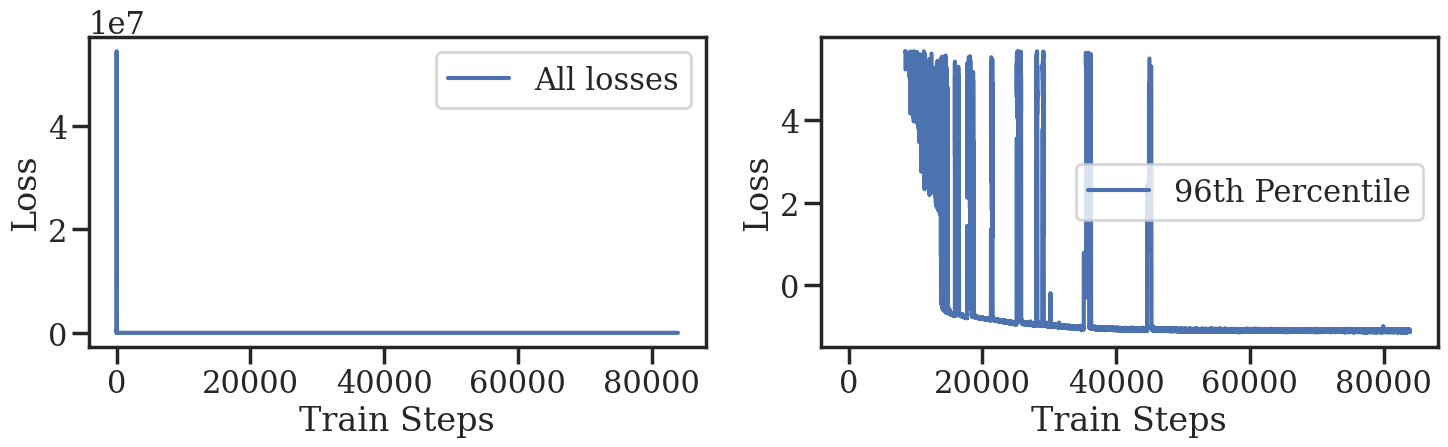

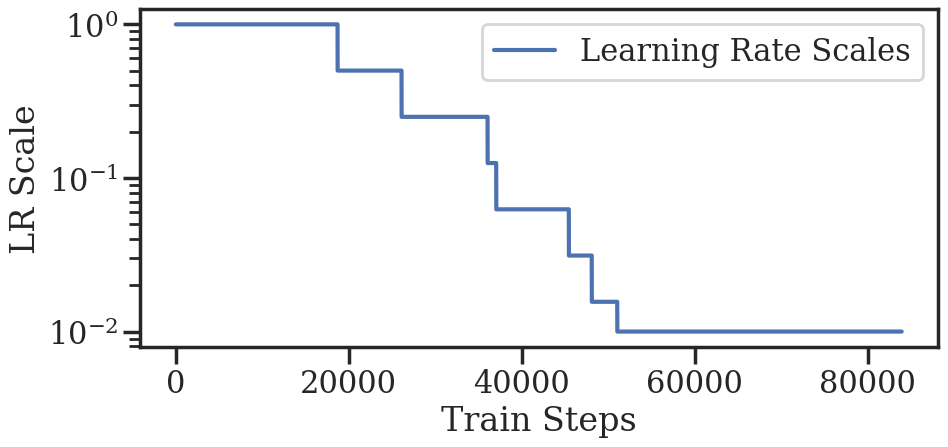

In [ ]:
# %%

if os.path.exists(run_folder+"losses.npy"):
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    clean_losses = np.array(losses)
    epochs = np.arange(len(losses))

    ax = sbplot(epochs, clean_losses, label="All losses", x_label='Train Steps', y_label='Loss', ax=ax, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

    clean_losses = np.where(clean_losses<np.percentile(clean_losses, 86), clean_losses, np.nan)
    ## Plot a second plot with the outliers removed
    ax2 = sbplot(epochs, clean_losses, label="96th Percentile", x_label='Train Steps', y_label='Loss', ax=ax2, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

    plt.legend()
    plt.draw();
    plt.savefig(run_folder+"loss.png", dpi=100, bbox_inches='tight')

else: ## Attempt to parse and collect losses from the nohup.log file
    try:
        with open(run_folder+"nohup.log", 'r') as f:
            lines = f.readlines()
        losses = []
        loss_name = "MSELoss" if use_mse_loss else "NLL Loss"
        for line in lines:
            if loss_name in line:
                loss = float(line.split(loss_name+": ")[1].strip())
                losses.append(loss)

        fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ## Filter outlier vales and retain the rest
        clean_losses = np.array(losses)
        epochs = np.arange(len(losses))

        ax = sbplot(epochs, clean_losses, label="All losses", x_label='Train Steps', y_label='Loss', ax=ax, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

        clean_losses = np.where(clean_losses<np.percentile(clean_losses, 96), clean_losses, np.nan)
        ## Plot a second plot with the outliers removed
        ax2 = sbplot(epochs, clean_losses, label="96th Percentile", x_label='Train Steps', y_label='Loss', ax=ax2, dark_background=False, y_scale="linear" if not use_mse_loss else "log");

        plt.legend()
        plt.draw();
        plt.savefig(run_folder+"loss.png", dpi=100, bbox_inches='tight')
    except:
        print("No losses found in the nohup.log file")


if os.path.exists(run_folder+"lr_scales.npy"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    clean_lr_scales = np.array(lr_scales)
    train_steps = np.arange(len(lr_scales))

    ax = sbplot(train_steps, clean_lr_scales, label="Learning Rate Scales", x_label='Train Steps', y_label='LR Scale', ax=ax, dark_background=False, y_scale="log");

    plt.legend()
    plt.draw();
    plt.savefig(run_folder+"lr_scales.png", dpi=100, bbox_inches='tight')

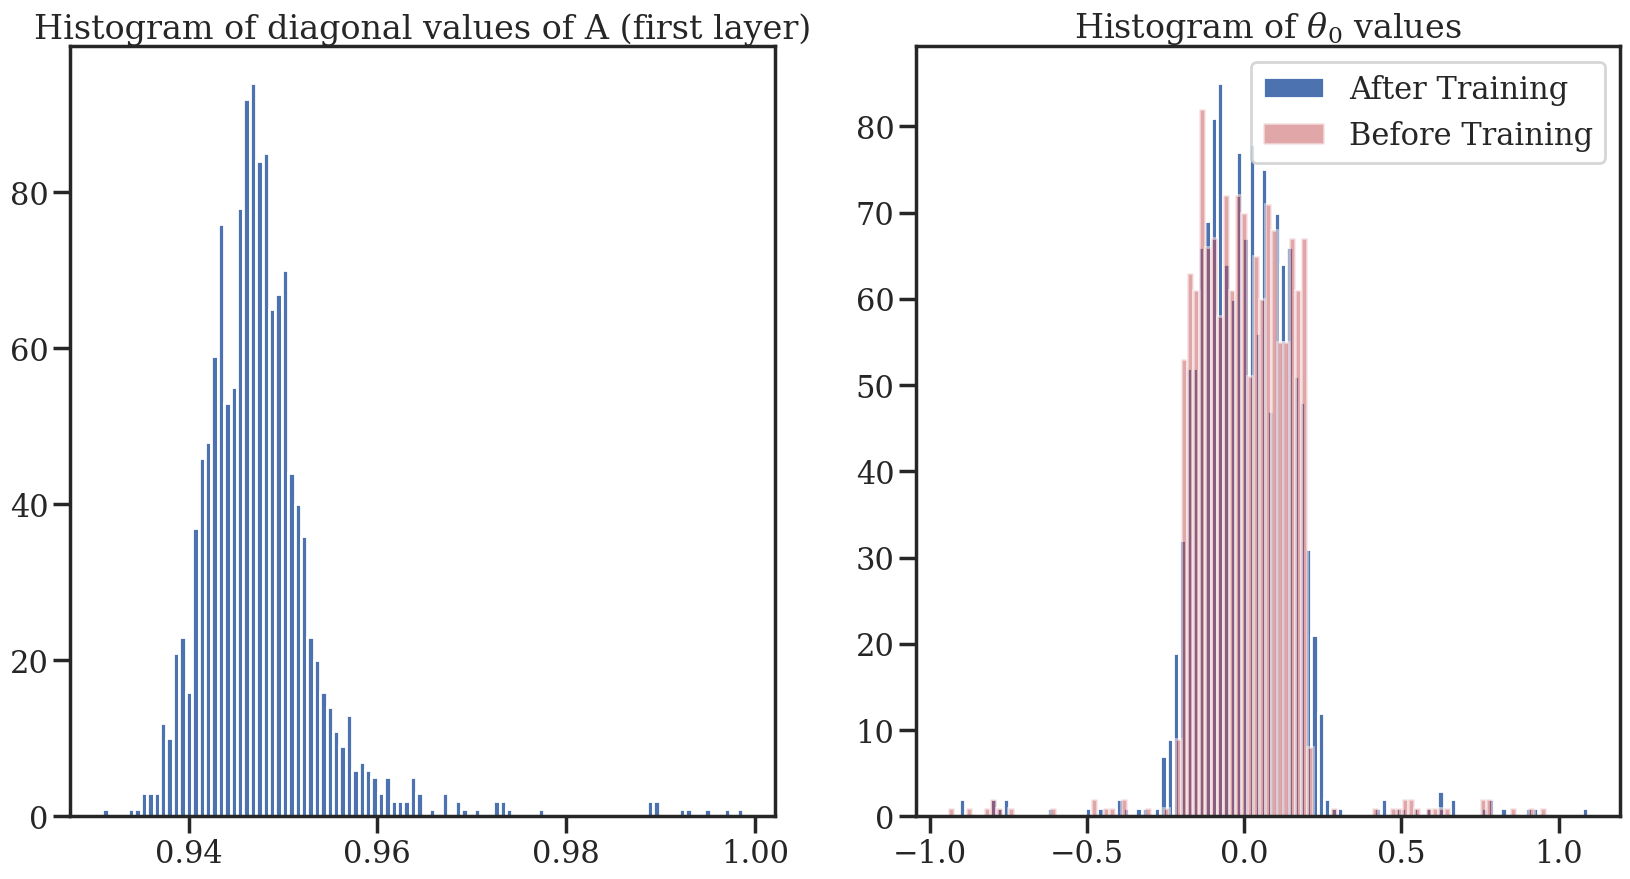

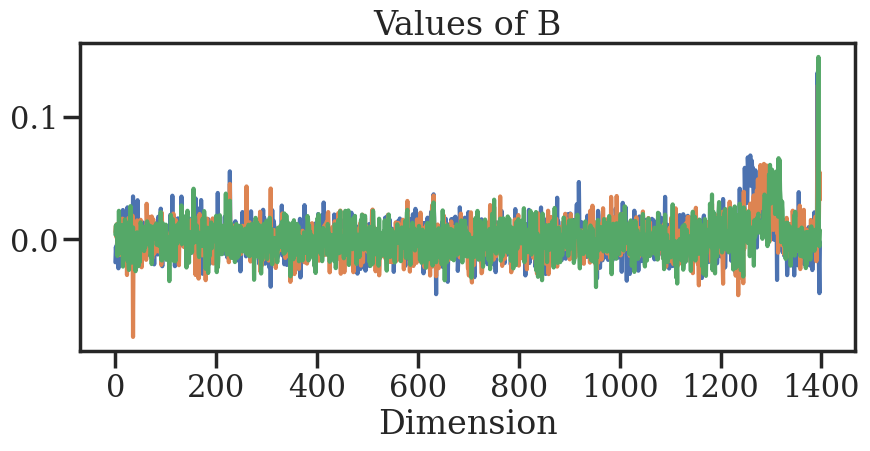

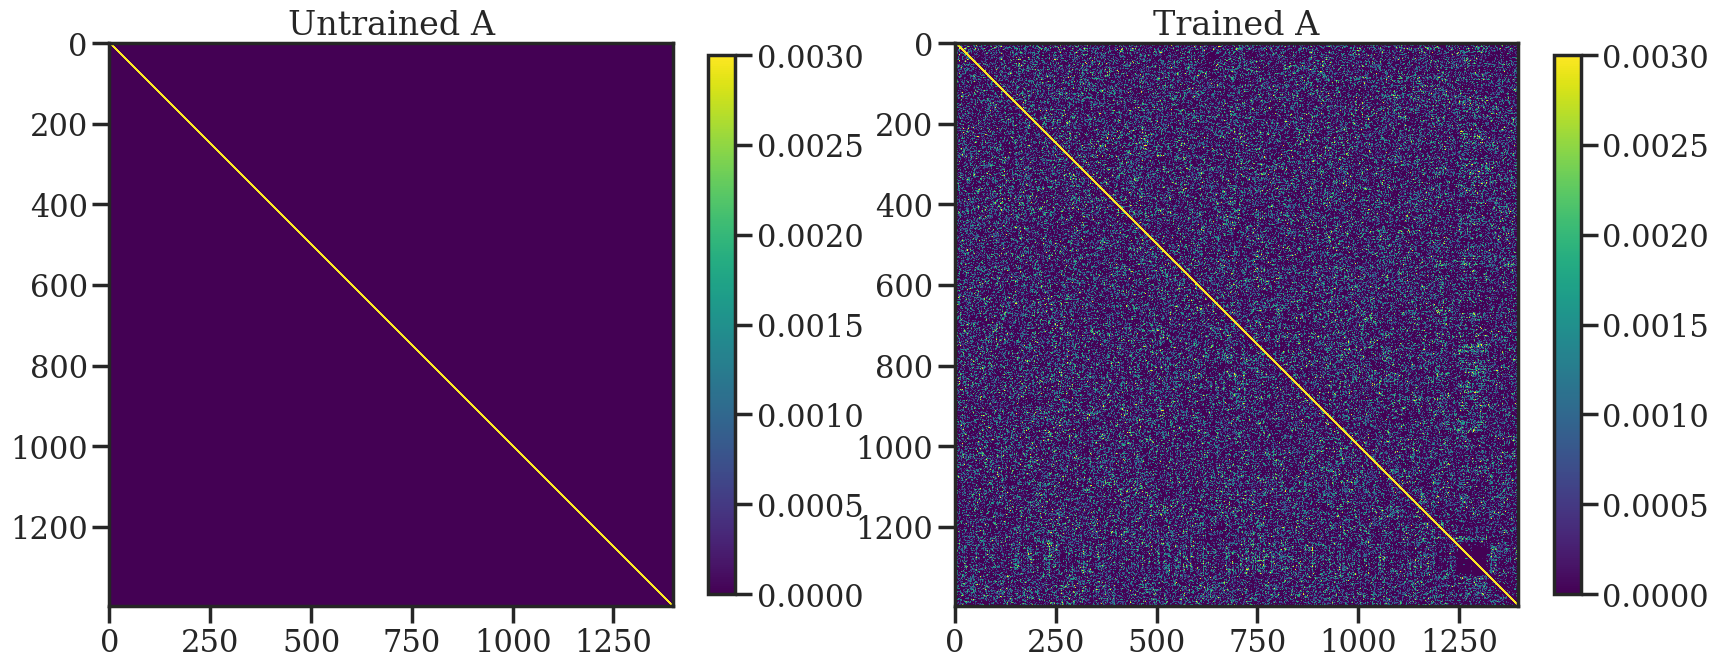

In [ ]:
# %%

## Print the value of alpha
# print("Alpha before training: (no teacher forcing)", 0.)
# print("Alpha after training:", model.alpha)

## Let's visualise the distribution of values along the main diagonal of A and theta
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
if full_matrix_A:
    axs[0].hist(jnp.diag(model.As[0], k=0), bins=100)
else:
    axs[0].hist(model.As[0], bins=100)

axs[0].set_title("Histogram of diagonal values of A (first layer)")

axs[1].hist(model.thetas[0], bins=100, label="After Training")
axs[1].hist(untrained_model.thetas[0], bins=100, alpha=0.5, label="Before Training", color='r')
axs[1].set_title(r"Histogram of $\theta_0$ values")
plt.legend();
plt.draw();
plt.savefig(run_folder+"A_theta_histograms.png", dpi=100, bbox_inches='tight')

## PLot all values of B in a lineplot (all dimensions)
if not isinstance(model.Bs[0], eqx.nn.Linear):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(model.Bs[0], label="Values of B")
    ax.set_title("Values of B")
    ax.set_xlabel("Dimension")
    plt.draw();
    plt.savefig(run_folder+"B_values.png", dpi=100, bbox_inches='tight')

if full_matrix_A:
    ## Print the untrained and trained matrices A as imshows with same range
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    # min_val = min(jnp.min(model.A), jnp.min(untrained_model.A))
    # max_val = max(jnp.max(model.A), jnp.max(untrained_model.A))
    min_val = -0.00
    max_val = 0.003

    img = axs[0].imshow(untrained_model.As[0], cmap='viridis', vmin=min_val, vmax=max_val)
    axs[0].set_title("Untrained A")
    plt.colorbar(img, ax=axs[0], shrink=0.7)

    img = axs[1].imshow(model.As[0], cmap='viridis', vmin=min_val, vmax=max_val)
    axs[1].set_title("Trained A")
    plt.colorbar(img, ax=axs[1], shrink=0.7)
    plt.draw();
    plt.savefig(run_folder+"A_matrices.png", dpi=100, bbox_inches='tight')

In [ ]:
# %%

## Let's evaluate the model on the test set
accs = []
mses = []
test_key, _ = jax.random.split(main_key)
for i, batch in enumerate(testloader):
    test_key, _ = jax.random.split(test_key)
    (X_true, times), X_labels = batch

    if supervision_task == "classification":
        X_classes = model(X_true, times, (alpha, test_key))
        pred_logits = X_classes[:, -1, :]   ## We only care about the last prediction: (batch, num_classes)
        acc = jnp.mean(jnp.argmax(pred_logits, axis=-1) == X_labels)
        accs.append(acc)

    elif supervision_task == "reconstruction":
        X_recons = model(X_true, times, (alpha, test_key))
        if not use_mse_loss:
            X_recons = X_recons[:, :, :data_size]
        mse = jnp.mean((X_recons - X_true)**2)
        mses.append(mse)

    else:
        X_full = model(X_true, times, (alpha, test_key))
        recons_size = data_size if use_mse_loss else 2*data_size
        X_recons, X_classes = X_full[:, :, :recons_size], X_full[:, :, recons_size:]

        mse = jnp.mean((X_recons - X_true)**2)
        mses.append(mse)

        acc = jnp.mean(jnp.argmax(X_classes[:, -1, :], axis=-1) == X_labels)
        accs.append(acc)

if supervision_task=="classification":
    print(f"Mean accuracy on the test set: {np.mean(accs)*100:.2f}%")
elif supervision_task=="reconstruction":
    print(f"Mean MSE on the test set: {np.mean(mses):.6f}")
else:
    print(f"Mean accuracy on the test set: {np.mean(accs)*100:.2f}%")
    print(f"Mean MSE on the test set: {np.mean(mses):.6f}")

Mean MSE on the test set: 0.048966


Min and max of the uncertainty: 0.03389228 1.0043354
Min and max of the uncertainty: 0.010312883 1.1362787
Min and max of the uncertainty: 0.03503663 0.82394415
Min and max of the uncertainty: 0.08957559 0.7384624
Min and max of the uncertainty: 0.06346019 0.73937535
Min and max of the uncertainty: 0.12951083 0.7357778
Min and max of the uncertainty: 0.061413616 0.73716235
Min and max of the uncertainty: 0.059063192 0.73663723
Min and max of the uncertainty: 0.03573645 1.1895912
Min and max of the uncertainty: 0.04515524 0.8690368
Min and max of the uncertainty: 0.068441145 0.7330086
Min and max of the uncertainty: 0.08173996 0.7433119
Min and max of the uncertainty: 0.04077892 0.9874945
Min and max of the uncertainty: 0.044342924 0.73859024
Min and max of the uncertainty: 0.044517133 0.73782015
Min and max of the uncertainty: 0.03628441 1.3930982


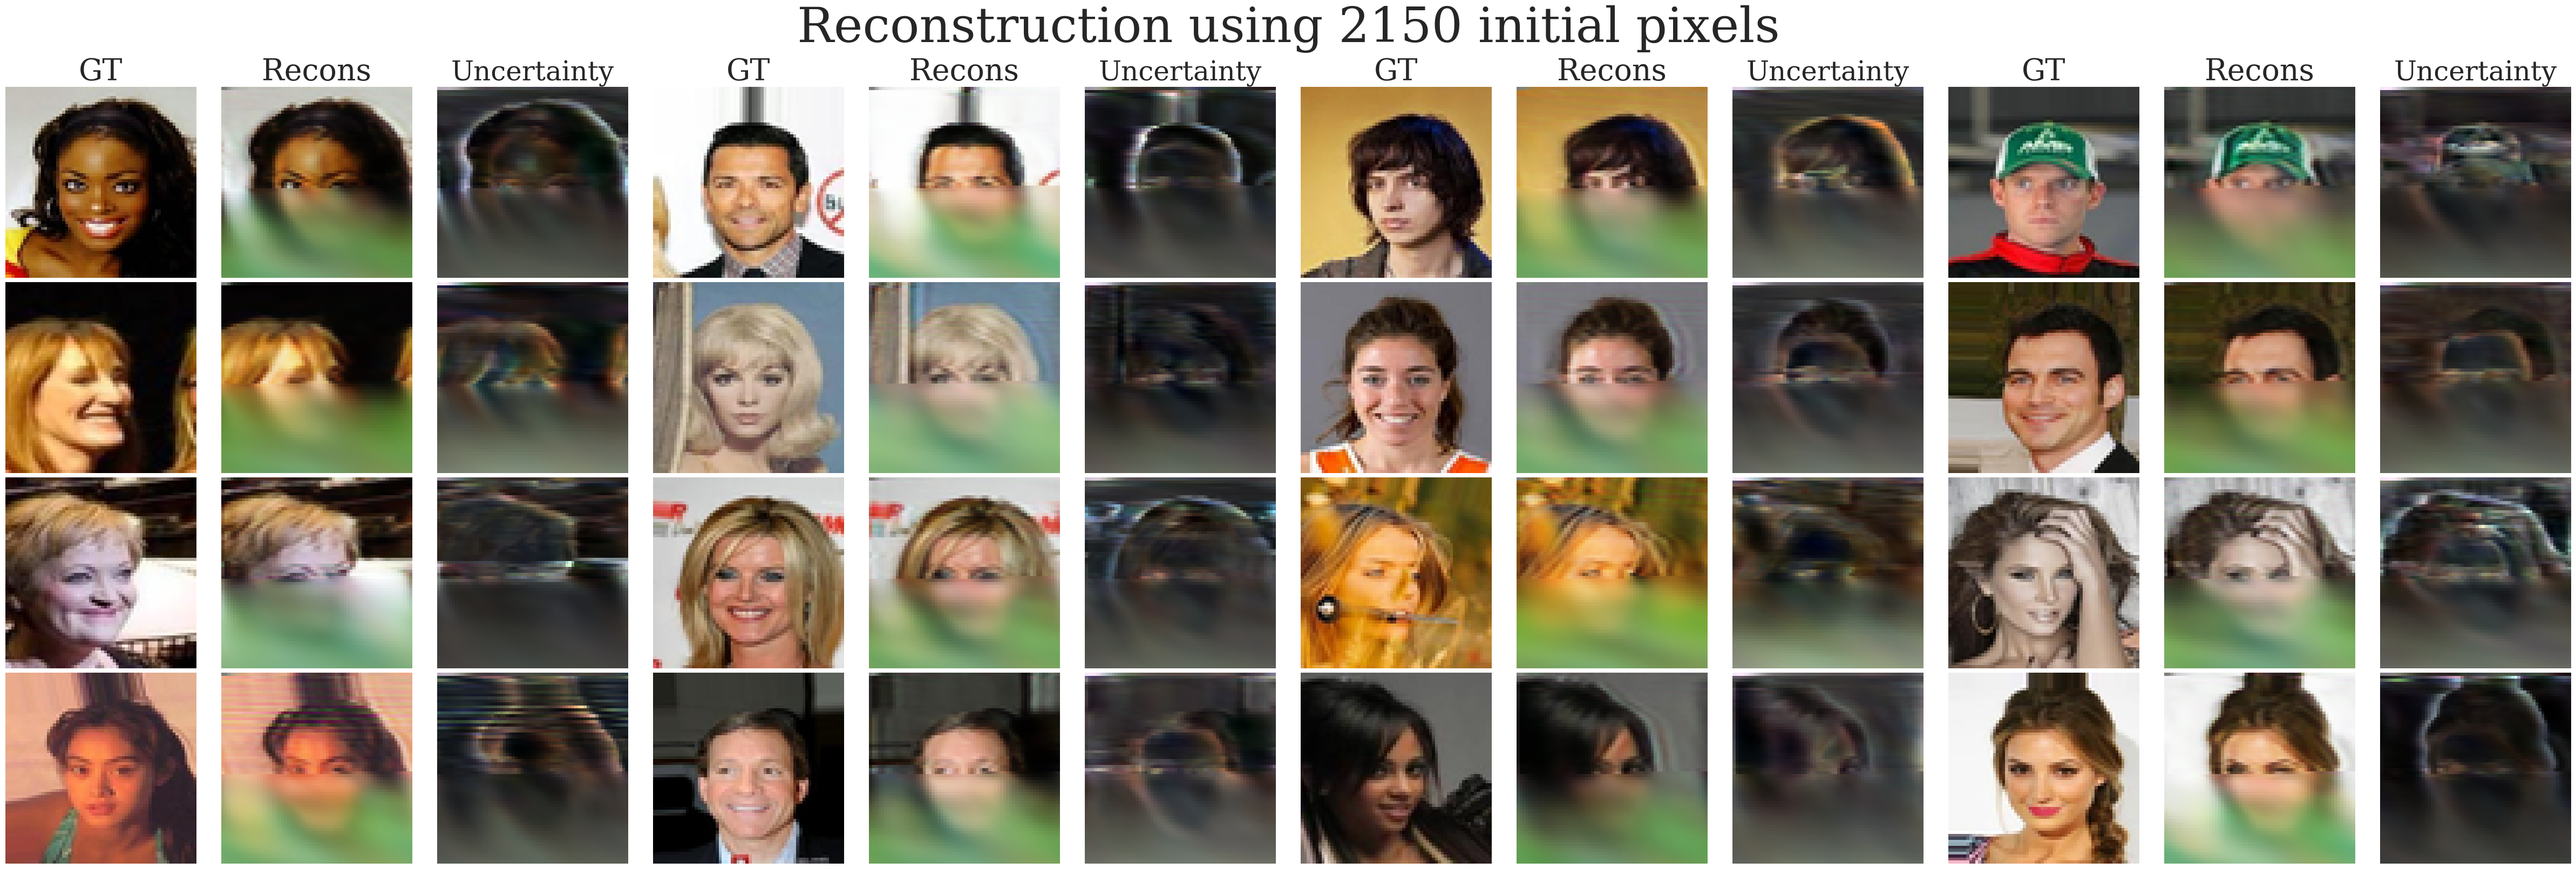

In [ ]:
# %%

## Let's visualise the reconstruction of a few samples only based on grounding information. PLot the true and the reconstructed images size by side

if not supervision_task=="classification":
    ## Set inference mode to True
    model = eqx.tree_at(lambda m:m.inference_mode, model, True)
    visloader = NumpyLoader(testloader.dataset, batch_size=16, shuffle=True)

    nb_cols = 3 if not use_mse_loss else 2
    fig, axs = plt.subplots(4, 4*nb_cols, figsize=(16*3, 16), sharex=True, constrained_layout=True)

    batch = next(iter(visloader))
    (xs_true, times), labels = batch
    xs_recons = model(xs_true, times, (alpha, test_key))

    if supervision_task != "reconstruction":
        xs_recons = xs_recons[:, :, :data_size*2]

    if not use_mse_loss:
        xs_uncert = xs_recons[:, :, data_size:]
        xs_recons = xs_recons[:, :, :data_size]

    width = get_width(dataset)
    res = (width, width, data_size)
    for i in range(4):
        for j in range(4):
            x = xs_true[i*4+j]
            x_recons = xs_recons[i*4+j]

            if dataset in image_datasets:
                to_plot = x.reshape(res)
                if (not unit_normalise) and (dataset=="celeba"):
                    to_plot = (to_plot + 1) / 2
                axs[i, nb_cols*j].imshow(to_plot, cmap='gray')
            else:
                axs[i, nb_cols*j].plot(x, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j].set_title("GT", fontsize=40)
            axs[i, nb_cols*j].axis('off')

            if dataset in image_datasets:
                to_plot = x_recons.reshape(res)
                if (not unit_normalise) and (dataset=="celeba"):
                    to_plot = (to_plot + 1) / 2
                axs[i, nb_cols*j+1].imshow(to_plot, cmap='gray')
            else:
                axs[i, nb_cols*j+1].plot(x_recons, color=colors[labels[i*4+j]])
            if i==0:
                axs[i, nb_cols*j+1].set_title("Recons", fontsize=40)
            axs[i, nb_cols*j+1].axis('off')

            if dataset in image_datasets and not use_mse_loss:
                to_plot = xs_uncert[i*4+j].reshape(res)
                print("Min and max of the uncertainty:", jnp.min(to_plot), jnp.max(to_plot))
                # if (not unit_normalise) and (dataset=="celeba"):
                if (not unit_normalise):
                    # to_plot = (to_plot + 1) / 2
                    # to_plot = enforce_positivity(to_plot)
                    ## Renormalise the uncertainty to be between 0 and 1
                    to_plot = (to_plot - jnp.min(to_plot)) / (jnp.max(to_plot) - jnp.min(to_plot))
                    axs[i, nb_cols*j+2].imshow(to_plot, cmap='gray')
                if i==0:
                    axs[i, nb_cols*j+2].set_title("Uncertainty", fontsize=36)
                axs[i, nb_cols*j+2].axis('off')

    plt.suptitle(f"Reconstruction using {grounding_length} initial pixels", fontsize=65)
    plt.draw();
    plt.savefig(run_folder+"reconstruction.png", dpi=100, bbox_inches='tight')

In [ ]:
#%%

## Copy nohup.log to the run folder
try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    os.system(f"cp nohup.log {run_folder}")